In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import joblib

In [55]:
data = pd.read_csv("/Users/navtejkumarsingh/Downloads/german_credit_flask_app/data/german_credit_data.csv")

In [56]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [57]:
data.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [59]:
data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
data['Checking account'].fillna(data['Checking account'].mode()[0], inplace=True)

/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_18302/1663771596.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Saving accounts'].fillna(data['Saving accounts'].mode()[0], inplace=True)
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_18302/1663771596.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


In [61]:
data.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


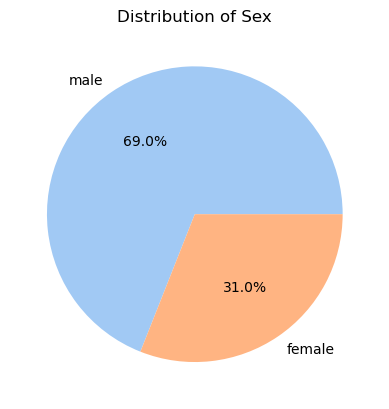

In [62]:
plt.pie(data['Sex'].value_counts(),
        autopct='%1.1f%%',
        labels=data['Sex'].unique(),
        colors=sns.color_palette("pastel")[0:2])  # Use Seaborn's pastel palette
plt.title('Distribution of Sex')
plt.show()


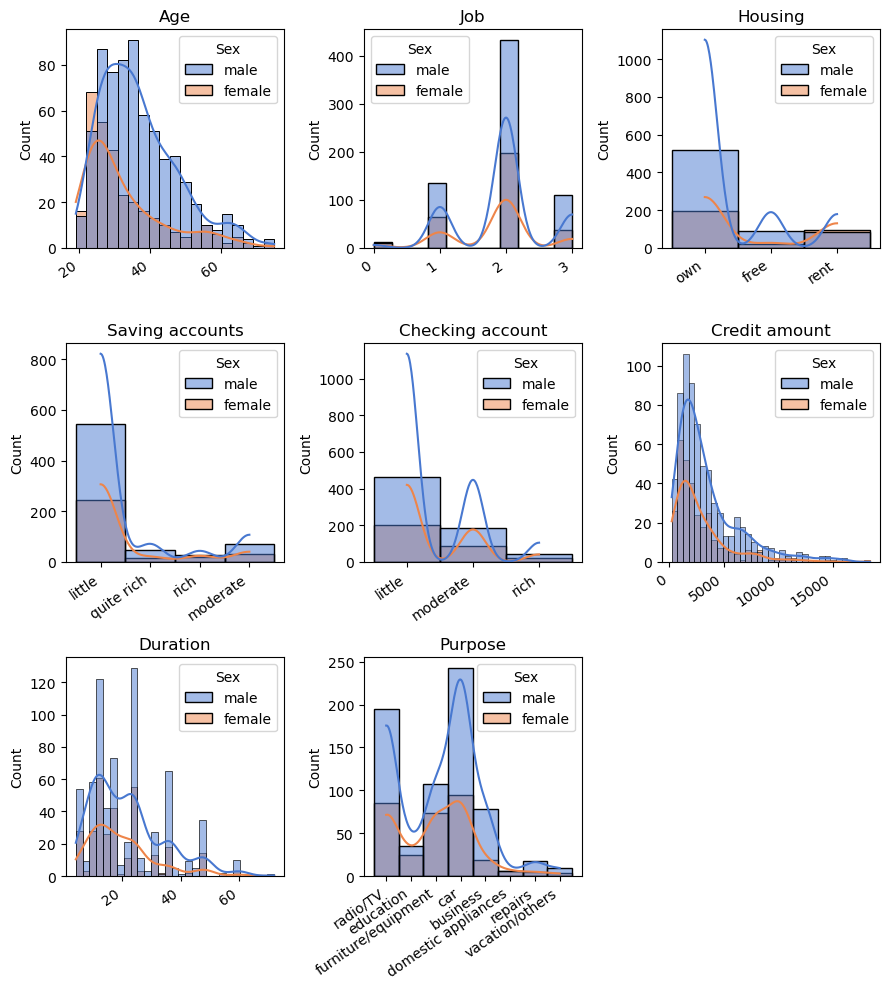

In [63]:
plt.figure(figsize=(9, 10))
dist = data.drop('Sex', axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(3, 3, i+1).set_title(col)
    sns.histplot(data=dist, x=dist.columns[i], hue=data['Sex'], kde=True, palette='muted')  # Using 'muted' palette
    plt.xticks(rotation=35, ha='right')
    plt.xlabel('')

plt.tight_layout()
plt.show()


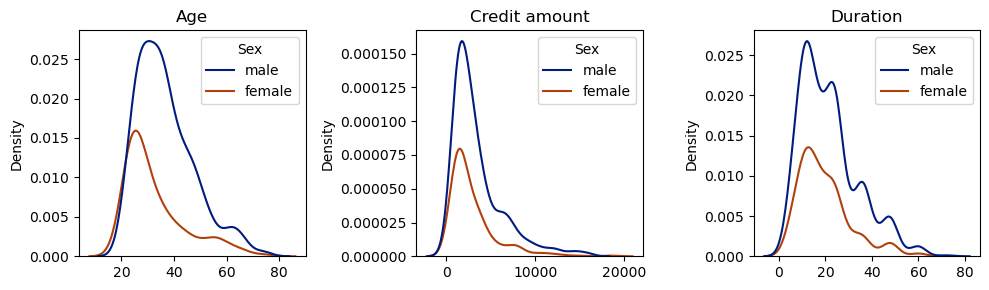

In [64]:
plt.figure(figsize=(10, 3))
dist = data.drop(['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(1, 3, i+1).set_title(col)
    sns.kdeplot(data=dist, x=dist.columns[i], hue=data['Sex'], palette='dark')  # Using 'dark' palette
    plt.xlabel('')

plt.tight_layout()
plt.show()


In [65]:
import numpy as np

# Randomly assign 'good' or 'bad' for demonstration
data['Risk'] = np.random.choice(['good', 'bad'], size=len(data))

# Then map it
data['Risk'] = data['Risk'].map({'good': 1, 'bad': 0})



cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
num_cols = ['Age', 'Job', 'Credit amount', 'Duration']

In [66]:
preprocessor = ColumnTransformer([
    ('num', MinMaxScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

In [67]:
X = data.drop('Risk', axis=1)
y = data['Risk']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [68]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_prob is not None:
        print("AUC Score:", roc_auc_score(y_test, y_prob))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

In [69]:
# Step 7: Logistic Regression (L1)
log_reg_l1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])
log_reg_l1.fit(X_train, y_train)
evaluate_model("Logistic Regression (L1)", log_reg_l1, X_test, y_test)



Logistic Regression (L1)
Accuracy: 0.48
Precision: 0.4626865671641791
Recall: 0.4246575342465753
F1 Score: 0.44285714285714284
AUC Score: 0.48438889877246044
Confusion Matrix:
 [[82 72]
 [84 62]]


In [70]:
# Step 8: Logistic Regression (L2)
log_reg_l2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l2'))
])
log_reg_l2.fit(X_train, y_train)
evaluate_model("Logistic Regression (L2)", log_reg_l2, X_test, y_test)


Logistic Regression (L2)
Accuracy: 0.49
Precision: 0.4755244755244755
Recall: 0.4657534246575342
F1 Score: 0.47058823529411764
AUC Score: 0.4798523394413805
Confusion Matrix:
 [[79 75]
 [78 68]]


In [71]:
# Step 9: Logistic Regression (No Reg)
log_reg_no_reg = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='none', solver='lbfgs', max_iter=200))
])
log_reg_no_reg.fit(X_train, y_train)
evaluate_model("Logistic Regression (No Reg)", log_reg_no_reg, X_test, y_test)


Logistic Regression (No Reg)
Accuracy: 0.48
Precision: 0.46621621621621623
Recall: 0.4726027397260274
F1 Score: 0.4693877551020408
AUC Score: 0.47798434442270055
Confusion Matrix:
 [[75 79]
 [77 69]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [72]:
# Step 10: K-Nearest Neighbors
knn = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=32))
])
knn.fit(X_train, y_train)
evaluate_model("K-Nearest Neighbors (K=32)", knn, X_test, y_test)


K-Nearest Neighbors (K=32)
Accuracy: 0.49666666666666665
Precision: 0.4825174825174825
Recall: 0.4726027397260274
F1 Score: 0.47750865051903113
AUC Score: 0.5145881515744529
Confusion Matrix:
 [[80 74]
 [77 69]]


In [73]:
# Step 11: Random Forest
rf = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)
evaluate_model("Random Forest (200 Trees)", rf, X_test, y_test)


Random Forest (200 Trees)
Accuracy: 0.4866666666666667
Precision: 0.47183098591549294
Recall: 0.4589041095890411
F1 Score: 0.4652777777777778
AUC Score: 0.5047811777263832
Confusion Matrix:
 [[79 75]
 [79 67]]


In [74]:
# Step 12: Gradient Boosting
gb = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
])
gb.fit(X_train, y_train)
evaluate_model("Gradient Boosting", gb, X_test, y_test)


Gradient Boosting
Accuracy: 0.49333333333333335
Precision: 0.4788732394366197
Recall: 0.4657534246575342
F1 Score: 0.4722222222222222
AUC Score: 0.49681996086105673
Confusion Matrix:
 [[80 74]
 [78 68]]


In [75]:
# Step 13: Stacking (KNN + Gradient Boosting)
estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=32)),
    ('gb', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
]

stacking_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
])
stacking_model.fit(X_train, y_train)
evaluate_model("Stacking (KNN + Gradient Boosting)", stacking_model, X_test, y_test)


Stacking (KNN + Gradient Boosting)
Accuracy: 0.5166666666666667
Precision: 0.5074626865671642
Recall: 0.2328767123287671
F1 Score: 0.3192488262910798
AUC Score: 0.4934397793986835
Confusion Matrix:
 [[121  33]
 [112  34]]


In [76]:
results = []
def log_results(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC Score": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

In [77]:

# Define models
log_reg_no_reg = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='none', solver='lbfgs', max_iter=200))
])
log_reg_no_reg.fit(X_train, y_train)
log_results("LogReg (No Reg)", log_reg_no_reg, X_test, y_test)

log_reg_l1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])
log_reg_l1.fit(X_train, y_train)
log_results("LogReg (L1)", log_reg_l1, X_test, y_test)

log_reg_l2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(penalty='l2'))
])
log_reg_l2.fit(X_train, y_train)
log_results("LogReg (L2)", log_reg_l2, X_test, y_test)

knn = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=32))
])
knn.fit(X_train, y_train)
log_results("KNN (K=32)", knn, X_test, y_test)

rf = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf.fit(X_train, y_train)
log_results("Random Forest", rf, X_test, y_test)

gb = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
])
gb.fit(X_train, y_train)
log_results("Gradient Boosting", gb, X_test, y_test)

stacking_model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier(n_neighbors=32)),
            ('gb', GradientBoostingClassifier(n_estimators=25, max_features=3, random_state=42))
        ],
        final_estimator=LogisticRegression()
    ))
])
stacking_model.fit(X_train, y_train)
log_results("Stacking (KNN + GB)", stacking_model, X_test, y_test)

smote_pipe = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])
smote_pipe.fit(X_train, y_train)
log_results("LogReg (SMOTE)", smote_pipe, X_test, y_test)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


In [78]:
results_df = pd.DataFrame(results)
results_df.sort_values(by="Accuracy", ascending=False, inplace=True)
print("\nModel Comparison:\n")
print(results_df)


Model Comparison:

                 Model  Accuracy  Precision    Recall  F1 Score  AUC Score
6  Stacking (KNN + GB)  0.516667   0.507463  0.232877  0.319249   0.493440
3           KNN (K=32)  0.496667   0.482517  0.472603  0.477509   0.514588
5    Gradient Boosting  0.493333   0.478873  0.465753  0.472222   0.496820
2          LogReg (L2)  0.490000   0.475524  0.465753  0.470588   0.479852
4        Random Forest  0.486667   0.471831  0.458904  0.465278   0.504781
0      LogReg (No Reg)  0.480000   0.466216  0.472603  0.469388   0.477984
1          LogReg (L1)  0.480000   0.462687  0.424658  0.442857   0.484389
7       LogReg (SMOTE)  0.473333   0.464706  0.541096  0.500000   0.480431


/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_18302/2436860962.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues_d")
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_18302/2436860962.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1 Score", y="Model", data=results_df, palette="Greens_d")
/var/folders/04/rstl77wx609gfy75bhwzv8400000gn/T/ipykernel_18302/2436860962.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AUC Score", y="Model", data=results_

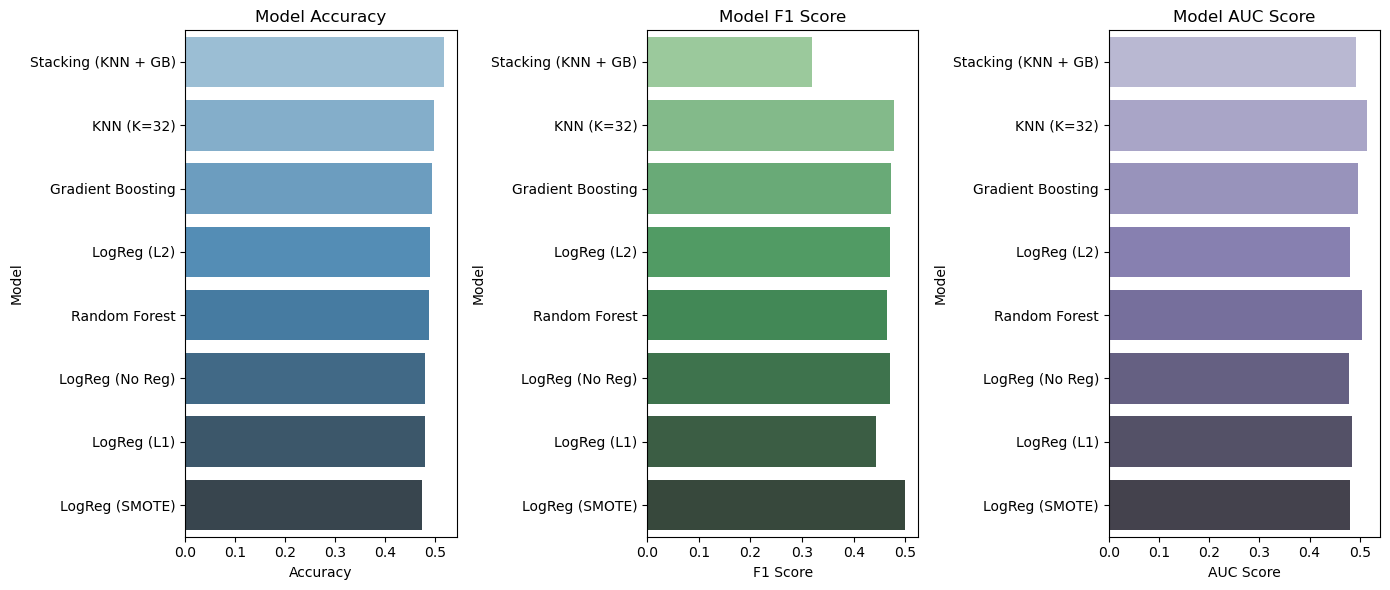

In [79]:
# Plot comparison
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="Blues_d")
plt.title("Model Accuracy")

plt.subplot(1, 3, 2)
sns.barplot(x="F1 Score", y="Model", data=results_df, palette="Greens_d")
plt.title("Model F1 Score")

plt.subplot(1, 3, 3)
sns.barplot(x="AUC Score", y="Model", data=results_df, palette="Purples_d")
plt.title("Model AUC Score")

plt.tight_layout()
plt.show()


In [82]:
mkdir -p model


In [83]:
import joblib

joblib.dump(stacking_model, "model/best_model_stacking_knn_gb.pkl")


['model/best_model_stacking_knn_gb.pkl']